## Определение перспективного тарифа для телеком компании


Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

#### Описание данных

**Таблица users (информация о пользователях):**
* user_id — уникальный идентификатор пользователя
* first_name — имя пользователя
* last_name — фамилия пользователя
* age — возраст пользователя (годы)
* reg_date — дата подключения тарифа (день, месяц, год)
* churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
* city — город проживания пользователя
* tariff — название тарифного плана     

**Таблица calls (информация о звонках):**
* id — уникальный номер звонка
* call_date — дата звонка
* duration — длительность звонка в минутах
* user_id — идентификатор пользователя, сделавшего звонок
* Таблица messages (информация о сообщениях):
* id — уникальный номер сообщения
* message_date — дата сообщения
* user_id — идентификатор пользователя, отправившего сообщение  

**Таблица internet (информация об интернет-сессиях):**
* id — уникальный номер сессии
* mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
* session_date — дата интернет-сессии
* user_id — идентификатор пользователя        

**Таблица tariffs (информация о тарифах):**
* tariff_name — название тарифа
* rub_monthly_fee — ежемесячная абонентская плата в рублях
* minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
* messages_included — количество сообщений в месяц, включённых в абонентскую плату
* mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
* rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
* rub_per_message — стоимость отправки сообщения сверх тарифного пакета
* rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

**Ход работы**
* чтение данных
* первичный осмотр данных
* нахождение ошибок
* исправление пропусков, форматов данных и ошибок
* сбор необходимой для исследования информации
* объединения информации в одну таблицу
* анализ данных и построение графиков
* проверка гипотез
* общий вывод

### Шаг 1. Откройте файл с данными и изучите общую информацию

импорт необходимых для работы библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats as st
import warnings 

In [2]:
warnings.simplefilter("ignore")

In [3]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

читаем файлы csv используя разделитель "**,**" и index_col=0, чтобы данные сохранялись без указания индекса

In [4]:
calls = pd.read_csv("/datasets/calls.csv", sep=",")
inet = pd.read_csv("/datasets/internet.csv", sep=",", index_col=0)
msg = pd.read_csv("/datasets/messages.csv", sep=",")
tarifs = pd.read_csv("/datasets/tariffs.csv", sep=",")
users = pd.read_csv("/datasets/users.csv", sep=",")

поэтапно выводим данные из каждой таблицы для первичного осмотра.

Для ускорения процесса создаю список с названиями используемых таблиц.

In [5]:
dict_datas=[calls, inet, msg, tarifs, users]
dict_datas_names = {'calls': calls, 'inet': inet, 'msg': msg, 'tarifs': tarifs, 'users': users}

Для вывода информации использую цикл **for** со значениями из списка с названиями таблиц

In [6]:
for name in dict_datas_names:
    
    print(color.BOLD + 'Таблица', name + color.END)
    display(dict_datas_names[name].head())
    print(color.BOLD + 'Общая информация о таблице', name + color.END)
    print('')
    dict_datas_names[name].info()
    print('')
    print('--------------------------------------------')
    print('')

Таблица calls


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


Общая информация о таблице calls

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB

--------------------------------------------

Таблица inet


,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


Общая информация о таблице inet

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB

--------------------------------------------

Таблица msg


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


Общая информация о таблице msg

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB

--------------------------------------------

Таблица tarifs


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Общая информация о таблице tarifs

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes

--------------------------------------------

Таблица users


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Общая информация о таблице users

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB

--------------------------------------------



#### Пропуски     
Первичный осмотр показал, что пропусков в данных нет. Всё очевидно можем дополнительно не проверять isnull isna.    
Пропуски есть только в churn_date, но как видно из описания проекта " дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)". Поэтому пропуски здесь допустимы.    
#### Ошибки формата
Найдены следующие ошибки форматов данных.     

**Таблица Calls**      
call_date - указана как object - необходимо datetime64	
 
**Таблица Inet**       
session_date - указана как object - необходимо datetime64	

**Таблица Msg**       
message_date - указана как object - необходимо datetime64	

**Таблица Users**         
reg_date - указана как object - необходимо datetime64	

#### Прочие ошибки
* В таблице **Inet** есть столбец **Unnamed**, которого нет в описании проекта, его необходимо убрать.
* В таблице **Calls** есть звонки с продолжительностью **0.0 секунд**, их мы учитывать не будем. Так как деньги за них не были сняты из за того, что фактически звонок не состоялся. Т.е. если их оставить значения по количеству звонок будут некорректны. Можем предположить, что это был звонок, когда дозвониться не удалось. Поэтому скорее всего звонили повторно т.е. можно сказать это "дубликат" звонка. **Будем удалять**

### Шаг 2. Подготовьте данные


#### Приведите данные к нужным типам;
Как показал первичный осмотр данных из таблиц, нам необходимо скорректировать форматы следующий столбцов таблиц.

<table align=left>
    <tr>
        <td><b>Таблица</b></td>
        <td><b>Столбец</b></td>
        <td><b>Текущий формат</b></td>
        <td><b>Необходимый формат</b></td>
    </tr>
    <tr>
        <td>Calls</td>
        <td>call_date</td>
        <td>object </td>
        <td>datetime64</td>
    </tr>
    <tr>
        <td>Inet</td>
        <td>session_date </td>
        <td>object </td>
        <td>datetime64</td>
    </tr>
    <tr>
        <td>Msg</td>
        <td>message_date </td>
        <td>object </td>
        <td>datetime64</td>
    </tr>
    <tr>
        <td>Users</td>
        <td>reg_date</td>
        <td>object </td>
        <td>datetime64</td>
    </tr>
<table>

меняем формат даты с помощью метода **pd.to_datetime**

In [7]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
inet['session_date'] = pd.to_datetime(inet['session_date'], format='%Y-%m-%d')
msg['message_date'] = pd.to_datetime(msg['message_date'], format='%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')



Проверяем результат с помощью цикла **for**

In [8]:
for source in dict_datas:
    source.info()
    print('')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null datetime64[ns]
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null datetime64[ns]
user_id         149396 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 5.7+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null datetime64[ns]
user_id         123036 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ 

Типы данных поменялись корректно, двигаемся дальше.

#### Найдите и исправьте ошибки в данных.

Теперь уберём из таблицы **Calls** звонки продолжительностью 0 секунд

*Я проверяю корректность удаление строк сравнивая "длину" таблицы с помощью **shape**, в более сложных случаях это не совсем информативно, но т.к. это не сложная сортировка считаю, что этого достаточно.*

In [9]:
calls.shape

(202607, 4)

Фильтруем все не нулевые значения с помощью **query** и сохраняем в том же датафрейме. 

In [10]:
calls = calls.query('duration >0')

In [11]:
calls.shape

(162994, 4)

Избалисись от нулей. Ура =) 

#### Округление вверх

Так как оператор округляет все нецелые значения вверх до целых необходимо округлить значения в:      
* таблица **inet** столбец **mb_used** 
* таблица **calls** столбец **duration**        

после этого можно рассчитать корректно стоимость звонков и трафика сверх тарифа.

Для округления пишем простую функцию использующую **ceil** из библиотеки ~~**math**~~ **numpy**

In [12]:
def rounded_value(row):
    rounded = np.ceil(row)
    return rounded

Применяем функцию с помощью **apply**

In [13]:
inet['mb_used'] = inet['mb_used'].apply(rounded_value)
calls['duration'] = calls['duration'].apply(rounded_value)

Проверяем корректность результата функции:

In [14]:
display(inet.head())
display(calls.head())

,id,mb_used,session_date,user_id
0,1000_0,113.0,2018-11-25,1000
1,1000_1,1053.0,2018-09-07,1000
2,1000_2,1198.0,2018-06-25,1000
3,1000_3,551.0,2018-08-22,1000
4,1000_4,303.0,2018-09-24,1000


,id,call_date,duration,user_id
2,1000_2,2018-06-11,3.0,1000
3,1000_3,2018-09-21,14.0,1000
4,1000_4,2018-12-15,6.0,1000
7,1000_7,2018-08-22,19.0,1000
8,1000_8,2018-09-15,19.0,1000


округление прошло корректно.

#### Расчёт дополнительных данных:

Для дальнейших исследований нам необходимо рассчитать следующие данные:
* количество сделанных звонков и израсходованных минут разговора по месяцам;
* количество отправленных сообщений по месяцам;
* объем израсходованного интернет-трафика по месяцам;
* помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

Для выборки по месяцам создадим новый столбец в каждой таблице с номером месяца с помощью **dt.month**                        
*так как из описания проекта ясно, что данные взяты только по одному году, нам хватит только номера месяца. Если бы данные были за несколько лет, нужно было бы учитывать ещё и год для корректной разбивки по месяцам*

In [15]:
calls['month']= calls['call_date'].dt.month
inet['month'] = inet['session_date'].dt.month
msg['month'] = msg['message_date'].dt.month


In [16]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162994 entries, 2 to 202606
Data columns (total 5 columns):
id           162994 non-null object
call_date    162994 non-null datetime64[ns]
duration     162994 non-null float64
user_id      162994 non-null int64
month        162994 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 7.5+ MB


С помощью **pivot_table** посчитаем необходимые данные по каждой из таблиц

In [17]:
calls_grouped = calls.pivot_table(index=['user_id','month'],values='duration',aggfunc = ['sum','count'] )

Переименуем столбцы, чтобы убрать "двойное название".

In [18]:
calls_grouped.columns =['sum_min','count_calls']

Проверим результат.

In [19]:
display(calls_grouped.head(15))

sum_min  count_calls
user_id month                      
1000    5        159.0           17
        6        172.0           28
        7        340.0           41
        8        408.0           42
        9        466.0           46
        10       350.0           44
        11       338.0           37
        12       333.0           38
1001    11       430.0           45
        12       414.0           47
1002    6        117.0           14
        7        214.0           21
        8        289.0           37
        9        206.0           25
        10       212.0           24

Аналогично предыдущему шагу.

In [20]:
msg_grouped = inet.pivot_table(index=['user_id','month'],values='id',aggfunc = ['count'] )

In [21]:
msg_grouped.columns=['msg_count']

In [22]:
display(msg_grouped.head(15))

msg_count
user_id month           
1000    5              5
        6             49
        7             29
        8             29
        9             27
        10            27
        11            24
        12            21
1001    11            55
        12            41
1002    6             34
        7             58
        8             60
        9             56
        10            44

Аналогично предыдущему шагу.

In [23]:
inet_grouped = inet.pivot_table(index=['user_id','month'],values='mb_used',aggfunc = ['sum'] )

In [24]:
inet_grouped.columns= ['sum_traffic']

In [25]:
display(inet_grouped.head(15))

sum_traffic
user_id month             
1000    5           2256.0
        6          23257.0
        7          14016.0
        8          14070.0
        9          14581.0
        10         14717.0
        11         14768.0
        12          9827.0
1001    11         18452.0
        12         14053.0
1002    6          10871.0
        7          17601.0
        8          20347.0
        9          16712.0
        10         13905.0

Сбросим индексы с помощью **reset_index** длая возможности дальнейшего использования этих столбцов.

In [26]:
calls_grouped.reset_index(inplace=True) 
inet_grouped.reset_index(inplace=True) 
msg_grouped.reset_index(inplace=True) 

Проверим результат.

In [27]:
display(calls_grouped.head())
display(inet_grouped.head())
display(msg_grouped.head())


,user_id,month,sum_min,count_calls
0,1000,5,159.0,17
1,1000,6,172.0,28
2,1000,7,340.0,41
3,1000,8,408.0,42
4,1000,9,466.0,46


,user_id,month,sum_traffic
0,1000,5,2256.0
1,1000,6,23257.0
2,1000,7,14016.0
3,1000,8,14070.0
4,1000,9,14581.0


,user_id,month,msg_count
0,1000,5,5
1,1000,6,49
2,1000,7,29
3,1000,8,29
4,1000,9,27


Данные по количеству звонков, их продолжительности, объёму трафика по месяцам собраны. Двигаемся дальше.

Объединим таблицы методом **merge**

In [28]:
all_data = calls_grouped.merge(inet_grouped, on=['user_id','month'], how='left')
all_data = all_data.merge(msg_grouped, on=['user_id','month'], how='left')
all_data = all_data.merge(users, on=['user_id'], how='left')

Так как таблица **tarifs** не имеет столбца **user_id** будем использовать другой для объединения, предварительно его переименовав для удобства с помощью **rename**

In [29]:
tarifs.rename(columns={'tariff_name': 'tariff'}, inplace=True)

присоединяем таблицу tarifs

In [30]:
all_data = all_data.merge(tarifs, on=['tariff'], how='left')

Проверяем резульат

In [31]:
display(all_data.head())

,user_id,month,sum_min,count_calls,sum_traffic,msg_count,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5,159.0,17,2256.0,5.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
1,1000,6,172.0,28,23257.0,49.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
2,1000,7,340.0,41,14016.0,29.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
3,1000,8,408.0,42,14070.0,29.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
4,1000,9,466.0,46,14581.0,27.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1


Облегчаем таблицу удалив ненужные для дальнейших расчётов столбцы с помощью **drop**

In [32]:
all_data = all_data.drop(['age', 'churn_date', 'first_name', 'last_name', 'reg_date'],1)


Проверяем результат.

In [33]:
display(all_data)

,user_id,month,sum_min,count_calls,sum_traffic,msg_count,city,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5,159.0,17,2256.0,5.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1
1,1000,6,172.0,28,23257.0,49.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1
2,1000,7,340.0,41,14016.0,29.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1
3,1000,8,408.0,42,14070.0,29.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1
4,1000,9,466.0,46,14581.0,27.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3163,1498,10,247.0,30,20604.0,59.0,Владикавказ,smart,50,15360,500,550,200,3,3
3164,1499,9,70.0,8,1848.0,5.0,Пермь,smart,50,15360,500,550,200,3,3
3165,1499,10,449.0,44,17809.0,58.0,Пермь,smart,50,15360,500,550,200,3,3
3166,1499,11,612.0,62,17984.0,49.0,Пермь,smart,50,15360,500,550,200,3,3


После осмотра видно, что столбцы **sum_traffic** и **msg_count** поменяли формат. Появилась дробная часть. 

Смотрим общую информацию по таблице.

In [34]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3168 entries, 0 to 3167
Data columns (total 15 columns):
user_id                  3168 non-null int64
month                    3168 non-null int64
sum_min                  3168 non-null float64
count_calls              3168 non-null int64
sum_traffic              3157 non-null float64
msg_count                3157 non-null float64
city                     3168 non-null object
tariff                   3168 non-null object
messages_included        3168 non-null int64
mb_per_month_included    3168 non-null int64
minutes_included         3168 non-null int64
rub_monthly_fee          3168 non-null int64
rub_per_gb               3168 non-null int64
rub_per_message          3168 non-null int64
rub_per_minute           3168 non-null int64
dtypes: float64(3), int64(10), object(2)
memory usage: 396.0+ KB


In [35]:
all_data.isnull().sum()

user_id                   0
month                     0
sum_min                   0
count_calls               0
sum_traffic              11
msg_count                11
city                      0
tariff                    0
messages_included         0
mb_per_month_included     0
minutes_included          0
rub_monthly_fee           0
rub_per_gb                0
rub_per_message           0
rub_per_minute            0
dtype: int64

В этих слобцах появились пропуски. Посмотрим в каких строчках эти пропуски.

In [36]:
display(all_data.query('sum_traffic == "NaN"'))

,user_id,month,sum_min,count_calls,sum_traffic,msg_count,city,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
1693,1273,5,220.0,19,NaN,NaN,Курган,ultra,1000,30720,3000,1950,150,1,1
1694,1273,6,230.0,28,NaN,NaN,Курган,ultra,1000,30720,3000,1950,150,1,1
1695,1273,7,253.0,30,NaN,NaN,Курган,ultra,1000,30720,3000,1950,150,1,1
1696,1273,8,253.0,39,NaN,NaN,Курган,ultra,1000,30720,3000,1950,150,1,1
1697,1273,9,223.0,28,NaN,NaN,Курган,ultra,1000,30720,3000,1950,150,1,1
1698,1273,10,315.0,35,NaN,NaN,Курган,ultra,1000,30720,3000,1950,150,1,1
1699,1273,11,272.0,31,NaN,NaN,Курган,ultra,1000,30720,3000,1950,150,1,1
1700,1273,12,260.0,38,NaN,NaN,Курган,ultra,1000,30720,3000,1950,150,1,1
2352,1377,2,179.0,20,NaN,NaN,Брянск,ultra,1000,30720,3000,1950,150,1,1
2465,1392,2,13.0,2,NaN,NaN,Челябинск,ultra,1000,30720,3000,1950,150,1,1


Не вижу связи по месяцам или городу использования или тарифу или же пользователям. Ошибки есть у разных абонентов из разных городов, используюзих разные тарифы 
Могу предположить, что абоненты просто не используют смс и интернет, а возможно используют нокию 3310, где оно и невозможно. Поэтому проставим 0 вместо пропусков.

Заполняем пропуски с помощью **fillna**

In [37]:
all_data = all_data.fillna(0)

Проверяем результат заполнения с помощью **insull и sum**

In [38]:
all_data.isnull().sum()

user_id                  0
month                    0
sum_min                  0
count_calls              0
sum_traffic              0
msg_count                0
city                     0
tariff                   0
messages_included        0
mb_per_month_included    0
minutes_included         0
rub_monthly_fee          0
rub_per_gb               0
rub_per_message          0
rub_per_minute           0
dtype: int64

Меняем формат данных этих столбцов с помощью **astype**

In [39]:
all_data['sum_traffic'] = all_data['sum_traffic'].astype('Int64')
all_data['msg_count'] = all_data['msg_count'].astype('Int64')

Смотрим результат.

In [40]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3168 entries, 0 to 3167
Data columns (total 15 columns):
user_id                  3168 non-null int64
month                    3168 non-null int64
sum_min                  3168 non-null float64
count_calls              3168 non-null int64
sum_traffic              3168 non-null Int64
msg_count                3168 non-null Int64
city                     3168 non-null object
tariff                   3168 non-null object
messages_included        3168 non-null int64
mb_per_month_included    3168 non-null int64
minutes_included         3168 non-null int64
rub_monthly_fee          3168 non-null int64
rub_per_gb               3168 non-null int64
rub_per_message          3168 non-null int64
rub_per_minute           3168 non-null int64
dtypes: Int64(2), float64(1), int64(10), object(2)
memory usage: 402.2+ KB


Всё корректно поменялось двигаемся дальше.

#### Расчёт помесячной платы за услуги сверх тарифа.

Для того, чтобы расчитать плату за услуги сверх тарифа, нам нужно понять сколько же было этих минут, мегабайт и смсок больше тарифа.     

Для этого создаём новый столбец для каждого типа услуги, где из суммарных показателей всех данных будем вычитать включённые в тариф услуги.



In [41]:
all_data['calculation_min'] = all_data['sum_min'] - all_data['minutes_included']
all_data['calculation_mb'] = all_data['sum_traffic'] - all_data['mb_per_month_included']
all_data['calculation_msg'] = all_data['msg_count'] - all_data['messages_included']

Проверяем результат.

In [42]:
display(all_data.head())

,user_id,month,sum_min,count_calls,sum_traffic,msg_count,city,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,calculation_min,calculation_mb,calculation_msg
0,1000,5,159.0,17,2256,5,Краснодар,ultra,1000,30720,3000,1950,150,1,1,-2841.0,-28464,-995
1,1000,6,172.0,28,23257,49,Краснодар,ultra,1000,30720,3000,1950,150,1,1,-2828.0,-7463,-951
2,1000,7,340.0,41,14016,29,Краснодар,ultra,1000,30720,3000,1950,150,1,1,-2660.0,-16704,-971
3,1000,8,408.0,42,14070,29,Краснодар,ultra,1000,30720,3000,1950,150,1,1,-2592.0,-16650,-971
4,1000,9,466.0,46,14581,27,Краснодар,ultra,1000,30720,3000,1950,150,1,1,-2534.0,-16139,-973


Пишем функцию для рассчёта услуг сверх тарифа. 
Если значение отрицательное т.е. абонент говорил меньше, предоплачено в тарифе. ( текущий объём - оплаченный)
То выводим 0.
Если значение положительное значит звонков или смс или трафика было больше, чем включено в тариф.
И мы присваем его в строку.

In [43]:
def over_limit(row):
    if row >0:
        return row
    else:
        return 0

Применяем функцию.

In [44]:
all_data['min_over_limit'] = all_data['calculation_min'].apply(over_limit)
all_data['msg_over_limit'] = all_data['calculation_msg'].apply(over_limit)
all_data['mb_over_limit'] = all_data['calculation_mb'].apply(over_limit)


Проверяем результат.

In [45]:
display(all_data.head())

,user_id,month,sum_min,count_calls,sum_traffic,msg_count,city,tariff,messages_included,mb_per_month_included,...,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,calculation_min,calculation_mb,calculation_msg,min_over_limit,msg_over_limit,mb_over_limit
0,1000,5,159.0,17,2256,5,Краснодар,ultra,1000,30720,...,1950,150,1,1,-2841.0,-28464,-995,0.0,0,0
1,1000,6,172.0,28,23257,49,Краснодар,ultra,1000,30720,...,1950,150,1,1,-2828.0,-7463,-951,0.0,0,0
2,1000,7,340.0,41,14016,29,Краснодар,ultra,1000,30720,...,1950,150,1,1,-2660.0,-16704,-971,0.0,0,0
3,1000,8,408.0,42,14070,29,Краснодар,ultra,1000,30720,...,1950,150,1,1,-2592.0,-16650,-971,0.0,0,0
4,1000,9,466.0,46,14581,27,Краснодар,ultra,1000,30720,...,1950,150,1,1,-2534.0,-16139,-973,0.0,0,0


Применяем функцию.

In [46]:
all_data['payment_min_over_limit'] = all_data['min_over_limit'] * all_data['rub_per_minute']
all_data['payment_msg_over_limit'] = all_data['msg_over_limit'] * all_data['rub_per_message']



Так как оператор взымает плату за интернет округляю до гигабайт, то нам необходимо также округлить значение.

Делим трафик сверх тарифа на 1024 (т.к. 1гб = 1024 мб)

In [47]:
all_data['mb_over_limit'] = all_data['mb_over_limit'] / 1024

округляем вверх используя функцию, которую мы написали ранее.

In [48]:
all_data['mb_over_limit'] = all_data['mb_over_limit'].apply(rounded_value)


Считаем плату сверх тарифа за траффик.

In [49]:
all_data['payment_mb_over_limit'] = all_data['mb_over_limit'] * all_data['rub_per_gb']


Проверяем результат.

In [50]:
display(all_data.head())

,user_id,month,sum_min,count_calls,sum_traffic,msg_count,city,tariff,messages_included,mb_per_month_included,...,rub_per_minute,calculation_min,calculation_mb,calculation_msg,min_over_limit,msg_over_limit,mb_over_limit,payment_min_over_limit,payment_msg_over_limit,payment_mb_over_limit
0,1000,5,159.0,17,2256,5,Краснодар,ultra,1000,30720,...,1,-2841.0,-28464,-995,0.0,0,0.0,0.0,0,0.0
1,1000,6,172.0,28,23257,49,Краснодар,ultra,1000,30720,...,1,-2828.0,-7463,-951,0.0,0,0.0,0.0,0,0.0
2,1000,7,340.0,41,14016,29,Краснодар,ultra,1000,30720,...,1,-2660.0,-16704,-971,0.0,0,0.0,0.0,0,0.0
3,1000,8,408.0,42,14070,29,Краснодар,ultra,1000,30720,...,1,-2592.0,-16650,-971,0.0,0,0.0,0.0,0,0.0
4,1000,9,466.0,46,14581,27,Краснодар,ultra,1000,30720,...,1,-2534.0,-16139,-973,0.0,0,0.0,0.0,0,0.0


Теперь мы можем поссчитать суммарный счёт за все услуги.

In [51]:
all_data['total_payment'] = all_data['payment_min_over_limit'] +\
                            all_data['payment_msg_over_limit'] +\
                            all_data['payment_mb_over_limit'] +\
                            all_data['rub_monthly_fee']

Проверяем результат.

In [52]:
display(all_data.head())

,user_id,month,sum_min,count_calls,sum_traffic,msg_count,city,tariff,messages_included,mb_per_month_included,...,calculation_min,calculation_mb,calculation_msg,min_over_limit,msg_over_limit,mb_over_limit,payment_min_over_limit,payment_msg_over_limit,payment_mb_over_limit,total_payment
0,1000,5,159.0,17,2256,5,Краснодар,ultra,1000,30720,...,-2841.0,-28464,-995,0.0,0,0.0,0.0,0,0.0,1950.0
1,1000,6,172.0,28,23257,49,Краснодар,ultra,1000,30720,...,-2828.0,-7463,-951,0.0,0,0.0,0.0,0,0.0,1950.0
2,1000,7,340.0,41,14016,29,Краснодар,ultra,1000,30720,...,-2660.0,-16704,-971,0.0,0,0.0,0.0,0,0.0,1950.0
3,1000,8,408.0,42,14070,29,Краснодар,ultra,1000,30720,...,-2592.0,-16650,-971,0.0,0,0.0,0.0,0,0.0,1950.0
4,1000,9,466.0,46,14581,27,Краснодар,ultra,1000,30720,...,-2534.0,-16139,-973,0.0,0,0.0,0.0,0,0.0,1950.0


### Шаг 3. Проанализируйте данные

Для анализа данных по тарифам нам необходимо создать новые таблицы по "тарифам"

Создаем новые таблицы с помощью **query**

In [53]:
ultra = all_data.query('tariff =="ultra"').copy()

In [54]:
smart = all_data.query('tariff =="smart"').copy()

Для автоматизации процесса постройки графиком будем использовать список с интересующими нас параметрами из таблицы и цикл **for**

Создаем список.  Также я создаю списки доя оформления графиков. Тут есть информация о подписях для осей, о самих названиях графиков, о лимитах по тарифам. :)

In [55]:
dict_tarif = ['sum_min', 'sum_traffic', 'msg_count', 'total_payment']
dict_legend__name_plot = {'sum_min' : 'График использованных минут в месяц',\
                    'sum_traffic':'График использования трафика в месяц',\
                    'msg_count': 'График отправленных смс в месяц',\
                    'total_payment':'График среднего платежа в месяц'}
dict_x_legend = {'sum_min' : 'Минуты',\
                    'sum_traffic':'Трафик',\
                    'msg_count': 'Собщения',\
                    'total_payment':'Сумма платежа'}
dict_limit_ultra = {'sum_min' : 3000,\
                    'sum_traffic':30720,\
                    'msg_count': 1000,\
                    'total_payment':1950}
dict_limit_smart = {'sum_min' : 500,\
                    'sum_traffic': 15360,\
                    'msg_count': 50,\
                    'total_payment': 550}

Запускаем цикл.

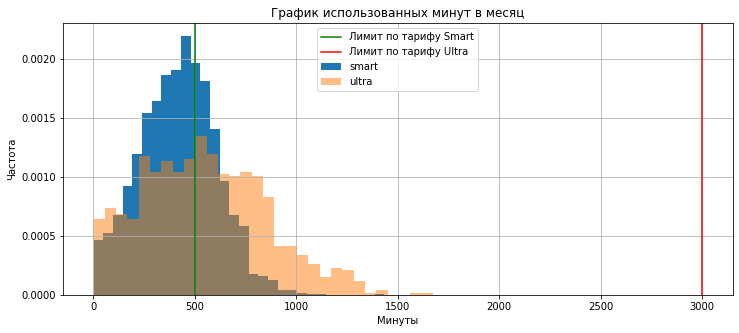

                                   Ящик с усами для тарифа Smart                                    


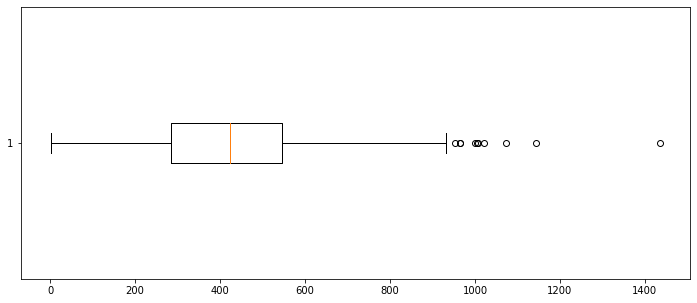

                                   Ящик с усами для тарифа Ultra                                    


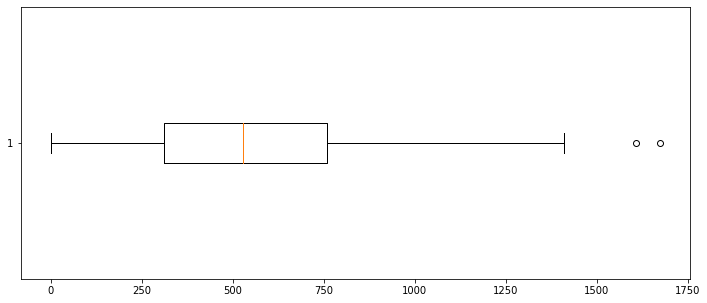

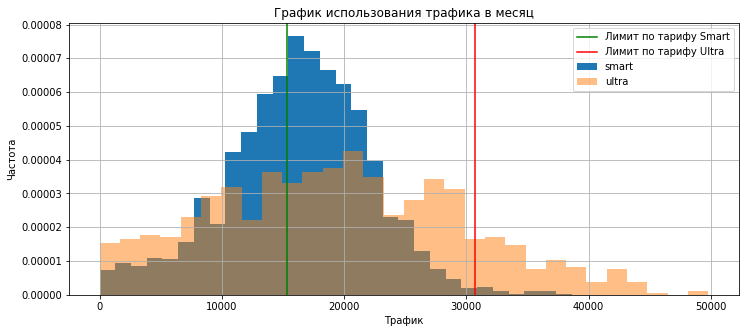

                                   Ящик с усами для тарифа Smart                                    


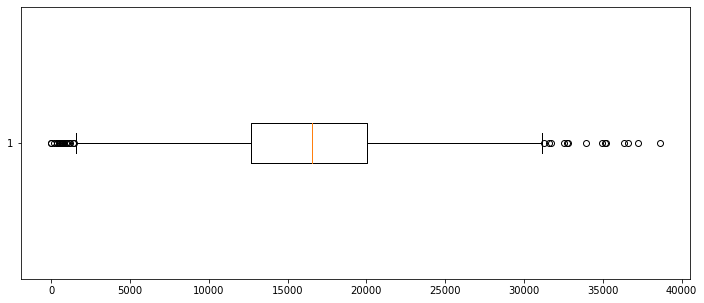

                                   Ящик с усами для тарифа Ultra                                    


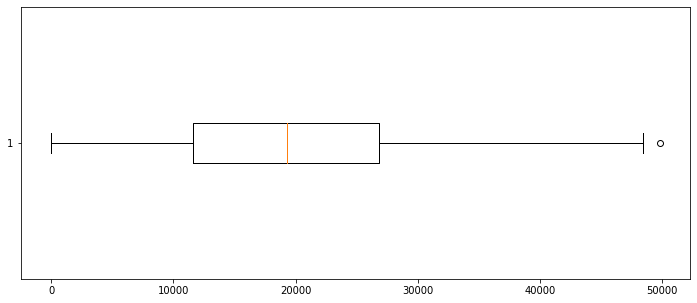

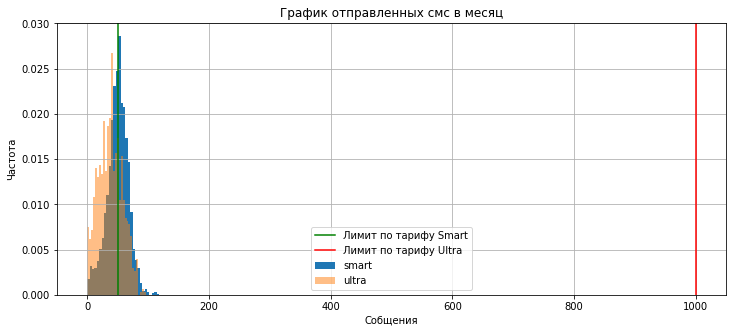

                                   Ящик с усами для тарифа Smart                                    


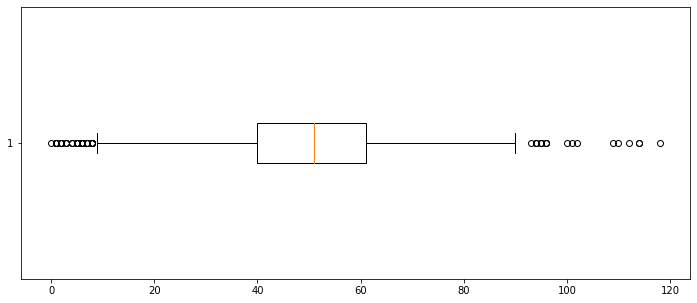

                                   Ящик с усами для тарифа Ultra                                    


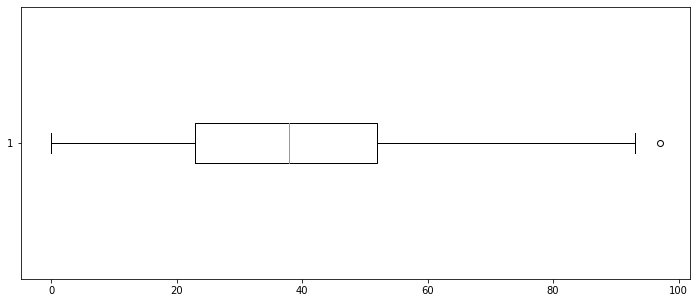

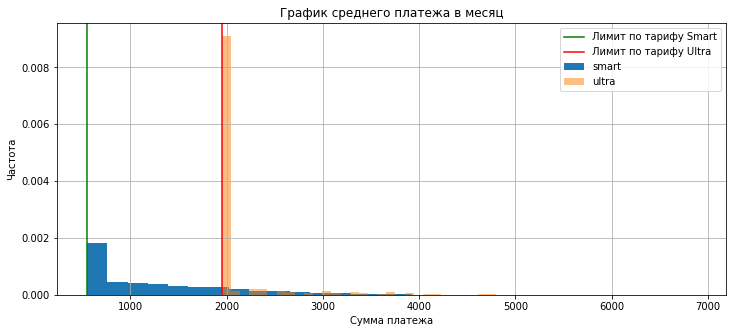

                                   Ящик с усами для тарифа Smart                                    


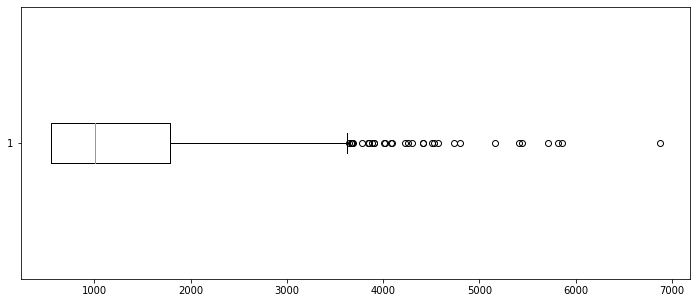

                                   Ящик с усами для тарифа Ultra                                    


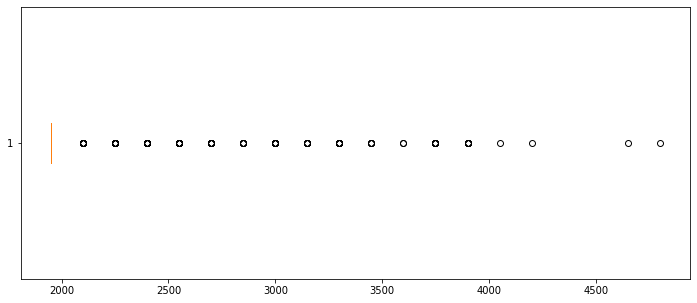

In [56]:
for source in dict_tarif:
    
    smart[source].plot(kind='hist', bins=30, label='smart', density=True, figsize=(12,5), grid=True)
    ultra[source].plot(kind='hist', bins=30, label='ultra', density=True, figsize=(12,5), alpha=0.5, grid=True)
    plt.title(dict_legend__name_plot[source])
    plt.xlabel(dict_x_legend[source])
    plt.ylabel('Частота')
    plt.axvline(x=dict_limit_smart[source], label='Лимит по тарифу Smart', color='green')
    plt.axvline(x=dict_limit_ultra[source], label='Лимит по тарифу Ultra', color='red')
    plt.legend()
    plt.show()
    print(color.BOLD + '{:^100s}'.format("Ящик с усами для тарифа Smart") + color.END)
    plt.figure(figsize=(12,5))
    plt.boxplot(smart[source], vert=False,)
    plt.show()
    print(color.BOLD + '{:^100s}'.format("Ящик с усами для тарифа Ultra") + color.END)
    plt.figure(figsize=(12,5))
    plt.boxplot(ultra[source], vert=False,)
    plt.show()


### Выводы:

**Минуты**
пользователи ultra больше звонят.

**Трафик**
пользователи ultra больше используют трафик.

**Сообщения**
Пользователи smart больше пишут смс

**Платёж**
Большинство пользователей ultra не выходят за рамки ежемесячной абонентской платы. Им хватает трафика смс и минут включённых в тариф.
Пользователи smart в среднем платят в 2 раза меньше.

Посчитаем среднее, дисперсию и отклонение для показателей для тарифов используя цикл **for**

In [57]:
dict_means={'sum_min' : 'использованных минут',\
                    'sum_traffic':'использованного трафика',\
                    'msg_count': 'использованныъ сообщенй',\
                    'total_payment':'сумарнного платежа'}

In [58]:
for source in dict_tarif:
    print('среднее',dict_means[source], 'тариф smart = {: <10.1f}'.format(smart[source].mean()))
    print('дисперсия', dict_means[source],'тариф smart = {: <10.1f}'.format(np.var(smart[source])))
    print('стандартное отклонение', dict_means[source],'тариф smart= {: <10.1f}'.format(np.std(smart[source])))
    print('')

среднее использованных минут тариф smart = 419.4     
дисперсия использованных минут тариф smart = 35702.0   
стандартное отклонение использованных минут тариф smart= 188.9     

среднее использованного трафика тариф smart = 16231.5   
дисперсия использованного трафика тариф smart = 34614950.1
стандартное отклонение использованного трафика тариф smart= 5883.4    

среднее использованныъ сообщенй тариф smart = 50.0      
дисперсия использованныъ сообщенй тариф smart = 302.0     
стандартное отклонение использованныъ сообщенй тариф smart= 17.4      

среднее сумарнного платежа тариф smart = 1298.4    
дисперсия сумарнного платежа тариф smart = 709149.0  
стандартное отклонение сумарнного платежа тариф smart= 842.1     



In [59]:
for source in dict_tarif:
    print('среднее',dict_means[source], 'тариф ultra = {: <10.1f}'.format(ultra[source].mean()))
    print('дисперсия', dict_means[source],'тариф ultra = {: <10.1f}'.format(np.var(ultra[source])))
    print('стандартное отклонение', dict_means[source],'тариф ultra= {: <10.1f}'.format(np.std(ultra[source])))
    print('')

среднее использованных минут тариф ultra = 547.8     
дисперсия использованных минут тариф ultra = 93239.9   
стандартное отклонение использованных минут тариф ultra= 305.4     

среднее использованного трафика тариф ultra = 19489.7   
дисперсия использованного трафика тариф ultra = 102759496.9
стандартное отклонение использованного трафика тариф ultra= 10137.0   

среднее использованныъ сообщенй тариф ultra = 38.4      
дисперсия использованныъ сообщенй тариф ultra = 386.5     
стандартное отклонение использованныъ сообщенй тариф ultra= 19.7      

среднее сумарнного платежа тариф ultra = 2072.4    
дисперсия сумарнного платежа тариф ultra = 146405.1  
стандартное отклонение сумарнного платежа тариф ultra= 382.6     



### Шаг 4. Проверьте гипотезы

Проверим наши гипотезы<font color=blue> из задания</font>:
* средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;
* средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов;


<font color=blue> Насколько я понял из задани мы имеем две гипотезы :              
1)средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;      
2) средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.     
    
Чтобы их проверить я выдвигаю свою нулевую и альтернативную гипотезу и делаю следующее:           
**Для первой гипотезы:**   
* Нулевая гипотеза: средняя выручка пользователей Ультра и смарт равны .     
* Альтернативная гипотеза: средня выручка пользователей Ультра и Смарт отличается.    
* сравниваю значения вручную     
* отвергаю или подтверждаю первоначальную гипотезу из пункта 1)          
          
**Для второй гипотезы:**    
* Нулевая гипотеза: средняя выручка пользователей из Москвы равна средней выручке пользователей других регионов.       
* Альтернативная гипотеза: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов     
* сравниваю значения вручную
* отвергаю или подтверждаю первоначальную гипотезу из пункта  2)

### Гипотеза средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;

Предположим, что средняя выручка по тарифам равна.

<font color=blue><b> Нулевая гипотеза: средняя выручка пользователей Ультра и смарт равны .    
    Альтернативная гипотеза: средня выручка пользователей Ультра и Смарт отличается.

In [60]:
alpha_tarif = 0.05

results_tarif = st.ttest_ind(
    ultra['total_payment'], 
    smart['total_payment'])

print('p-значение:', results_tarif.pvalue)

if (results_tarif.pvalue < alpha_tarif):
    print(color.BOLD + "Отвергаем нулевую гипотезу" + color.END)
else:
    print(color.BOLD + "Не получилось отвергнуть нулевую гипотезу" + color.END)

p-значение: 1.0583674938938247e-145
Отвергаем нулевую гипотезу


Сравним средние значения.

In [61]:
print('средняя выручка абонентов Ultra', ultra['total_payment'].mean())
print('средняя выручка абонентов Smart', smart['total_payment'].mean())

средняя выручка абонентов Ultra 2072.4392819429777
средняя выручка абонентов Smart 1298.4448446645656


Как мы видим, абоненты ultra платят почти в два раза больше.

**Гипотеза средняя выручка пользователей тарифов «Ультра» и «Смарт» различается - <font color=red>подтверждена</font>**

### Гипотеза средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

<font color=blue><b> Нулевая гипотеза:  средняя выручка пользователей из Москвы равна средней выручке пользователей других регионов.    
    Альтернативная гипотеза: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Сделаем выборки по городам.

In [62]:
users_moscow = all_data.query('city == "Москва"').copy()
users_other = all_data.query('city != "Москва"').copy()

**Гипотеза, что средняя выручка равна.**

In [63]:
alpha_cities = 0.01

results_cities = st.ttest_ind(
    users_moscow['total_payment'], 
    users_other['total_payment'])

print('p-значение:', results_cities.pvalue)

if (results_cities.pvalue < alpha_cities):
    print(color.BOLD + "Отвергаем нулевую гипотезу"  + color.END)
else:
    print(color.BOLD + "Не получилось отвергнуть нулевую гипотезу" + color.END)

p-значение: 0.40850223576502664
Не получилось отвергнуть нулевую гипотезу


**У нас неполучилось отвергнуть нулевую гипотезу.**

Посмотрим на средние показали по выручке в Москве и в других городах.

In [64]:
print('средняя выручка абонентов из Москвы {: <10.2f}'.format(users_moscow['total_payment'].mean()))
print('средняя выручка абонентов из других регионов {: <10.2f}'.format(users_other['total_payment'].mean()))

средняя выручка абонентов из Москвы 1554.37   
средняя выручка абонентов из других регионов 1523.96   


**Выручки практически одинакова.**

**Гипотеза средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов - <font color=red>отвергнута</font>**

### Шаг 5. Напишите общий вывод

* Абоненты тарифа Ultra приносят в среднем больше денег оператору.
* Абонентам Ultra хватает минут, смс и трафика включённых в тариф.
* Абоненты ультра в среднем больше звонят, пользуются интернетом, но меньше пишут смс.
* Абоненты smart стараются умещаться в предоплаченые минуты, смс и гигабайты, но часто бывают превышения.
* Гипотеза Гипотеза средняя выручка пользователей тарифов «Ультра» и «Смарт» различается - подтверждена
* Гипотеза средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов - отвергнута
* Абоненты Ultra приносят больше прибыли, чем абоненты Smart
* Тариф Ultra является более перспективным.
